Clase 10
===

Objetivos

* Introducción a dFBA
* Resolución de ODEs con scipy.

Ya estamos en la 4ta unidad en donde aprenderás a aplicar FBA bajo las condiciones dinámicas de cultivos por lote. En FBA dinámico (en adelante dFBA por su acrónimo en inglés: dynamic FBA) la evolución de la concetración de los metabólitos intracelulares durante la fermentación modifica las restricciones del FBA, cuyo resultado a su vez modifica los flujos de consumo y producción de las ecuaciones cinéticas.

Introducción a dFBA
----------------------

En un cultivo por lotes en donde puede haber alimentación.

<img src="https://raw.githubusercontent.com/modcommet/Clases/master/clase10_reactor.png" alt="Drawing" style="width: 200px;"/>

la biomasa aumenta, los sustratos se consumen, y los productos se acumulan. El siguiente gráfico corresponde a las variaciones del sustrato limitante (**Glu**:Glucosa), biomasa (**X**), y producto (**Eth**:Etanol) en un cultivo por lote alimentado de *Saccharomyces cerevisiae*. 

<img src="https://raw.githubusercontent.com/modcommet/Clases/master/clase10_cinetica.png" alt="Drawing" style="width: 500px;"/>

Matematicamente podemos reprentar este comportamiento dinámico realizando balances de masa a cada compuesto de interes. En nuestro ejemplo, **el modelo dinámico** es:

\begin{align}
\frac{dV}{dt} &=   F \\
\frac{dVX}{dt} &=\mu (VX) \\
\frac{dVGlu}{dt} &=F Glu_F-v_{Glu} MW_{Glu} (VX) \\
\frac{dVEth}{dt} &=v_{Eth} MW_{Eth} (VX) \\
\frac{dVGly}{dt} &=v_{Gly} MW_{Gly} (VX) \\
\frac{dVCit}{dt} &=v_{Cit} MW_{Cit} (VX) \\
\frac{dVLac}{dt} &=v_{Lac} MW_{Lac} (VX)] 
\end{align}

En donde los **flujos metabólicos** tanto de producción de biomasa ($\mu$) como de metabolitos ($v_{Eth}, v_{Gly}, v_{Cit}, v_{Lac}$) son computados por FBA:

\begin{align}
\mbox{max}\ & c^Tv \\
\mbox{s.a.} & \\
&\ Av=0 \\
&\ LB<=v<=UB
\end{align}

Como FBA está parametrizado en base al flujo de sustrato limitante, debemos definir una **cinética** para el mismo, la cual nos permita calcular valores de $v_Glu$ en función de las condiciones del medio de cultivo. Por ejemplo, [Sanches et al](http://www.sciencedirect.com/science/article/pii/S1096717614000950) modelaron $v_Glu$ con una expresion de tipo Monod, la cual está basada con inhibición por producto:


\begin{align}
v_{Glu}&=v_{Gmax}\frac{Glu}{K_{Glu}+Glu}\frac{1}{(1+Eth/K_{Eth})} 
\end{align}

Podemos pensar en cada uno de estos (cinética, metabólica, y dinámica) de manera modular,los cuales se pueden implementar en Python de la siguiente manera:

``` python 
# Kinetic block
def kineticBlock(Glu,Eth):
    # Parameters
    vGmax, K_Glu, K_Eth = 22.5, 0.88, 6.74
    f_Eth,f_Gly, f_Cit, f_Lac = .112, .273, .169, .137
    v_Glu=vGmax*Glu/(K_Glu+Glu)*1/(1+Eth/K_Eth)
    LB_Eth = v_Glu*f_Eth
    LB_Gly = v_Glu*f_Gly
    LB_Cit = v_Glu*f_Cit
    LB_Lac = v_Glu*f_Lac
    #LB_ATP_Ex = m_ATP
    return [v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac]

# Metabolic block
def metabolicBlock(v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac):
    model.reactions.get_by_id("EX_glc__D_e").lower_bound = -v_Glu # set flux of glucose
    model.reactions.get_by_id("EX_glc__D_e").upper_bound = -v_Glu # set flux of glucose
    solution = model.optimize()
    u = solution.f
    v_Eth = model.reactions.get_by_id("EX_etoh_e").x
    v_Gly = model.reactions.get_by_id("EX_glyc_e").x
    v_Cit = model.reactions.get_by_id("EX_cit_e").x
    v_Lac = model.reactions.get_by_id("EX_lac__D_e").x
    return [u, v_Eth, v_Gly, v_Cit, v_Lac]
    
# Dynamic block
def f(y,t,params):
    V,VX,VGlu,VEth,VGly,VCit,VLac = y # Current values
    F,u, v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params  # unpack parameters
    Glu_F = 300 # Glucose concentration on feed
    MW_Glu,MW_Eth,MW_Gly,MW_Cit,MW_Lac = [0.18,.046,.092,.192,.090]
    derivs=[F,                  # dV/dt
            u*VX,                # dVX/dt
            F*Glu_F-v_Glu*MW_Glu*(VX), # dVGlu/dt
            v_Eth*MW_Eth*(VX), # dVEth/dt
            v_Gly*MW_Gly*(VX), # dVGly/dt
            v_Cit*MW_Cit*(VX), # dVCit/dt
            v_Lac*MW_Lac*(VX)] # dVLac/dt
    return derivs
def dynamicBlock(y,params, ti,tf):
    time=np.linspace(ti,tf,100)
    #F,u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params
    soln = odeint(f,y,time,args=(params,))
    V=soln[-1,0]
    X,Glu,Eth,Gly,Cit,Lac=soln[-1,1:7]/V
    return [V,X,Glu,Eth,Gly,Cit,Lac]    


# Running the simulation over time
time=np.linspace(0,22,200)
for i in range(len(time)):
    # KINETIC BLOCK: 
    # given the current concentrations of glucose (Glu) and ethanol (Eth)
    # we compute the fluxes of Glu, and upper and lower limits of Eth, Glycerol(Gly), Citrate(Cit), and Lactate(Lac)
    v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac = kineticBlock(Glu,Eth)
    # METABOLIC BLOCK
    # given v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac
    # we compute biomass growth rate (u) and metabolic fluxes of extracellular metabolites
    u,v_Eth, v_Gly, v_Cit, v_Lac = metabolicBlock(v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac)
    # DYNAMIC BLOCK
    # given u, V, fluxes (v_Eth, v_Gly, v_Cit, v_Lac), and concentrations (X,Glu,Eth,Gly,Cit,Lac)
    # we update reaction volume V, X and Glu,Eth,Gly,Cit,Lac
    y = [V,X*V,Glu*V,Eth*V,Gly*V,Cit*V,Lac*V]
    params = [F(time[i]),u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac]
    V,X,Glu,Eth,Gly,Cit,Lac = dynamicBlock(y, params, time[i],time[i+1])

```




El bloque dinámico implica resolver sistema de ecuaciones diferenciales por cada iteración en el tiempo. Hoy, el foco de la clase es la resolución de ecuaciones diferenciales (ODEs por su acrónimo en inglés) ordinarias en Python. Luego en las siguientes clases nos enfocaremos en los otros dos bloques.  

Nota: Los siguientes dos ejemplos fueron extraidos desde [aquí](https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations).

Ejercicio 1
-------------

Resolver el siguiente ODE:

$\frac{dy}{dt}=-ky$

con condición inicial $y_0=5$, y un valor de $k=0.3$.

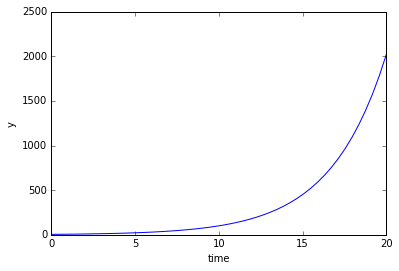

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dy/dt
def model(y,t):
    k = 0.3
    dydt = k * y
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20)

# solve ODE
y = odeint(model,y0,t)

# plot results
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('y')
plt.show()

Ejercicio 2
-------------

Resolver el siguiente ODE anterior pero esta vez para valores de $k$ igual a 0.1, 0.2, y 0.5.

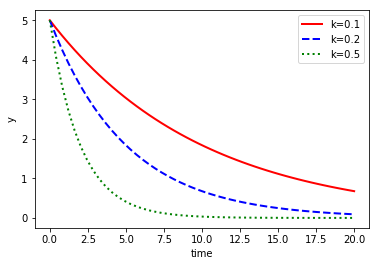

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dy/dt
def model(y,t,k):
    dydt = -k * y
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20)

# solve ODEs
k = 0.1
y1 = odeint(model,y0,t,args=(k,))
k = 0.2
y2 = odeint(model,y0,t,args=(k,))
k = 0.5
y3 = odeint(model,y0,t,args=(k,))

# plot results
plt.plot(t,y1,'r-',linewidth=2,label='k=0.1')
plt.plot(t,y2,'b--',linewidth=2,label='k=0.2')
plt.plot(t,y3,'g:',linewidth=2,label='k=0.5')
plt.xlabel('time')
plt.ylabel('y')
plt.legend()
plt.show()

Ejercicio 3
-------------

Veamos como resolver un sistema de ecuaciónes diferenciales ordinarias a través de un problema concreto: cinética enzimática

Una reacción enzimática puede ser modelada como:

<img src="https://raw.githubusercontent.com/modcommet/Clases/master/clase10_enzyme_reaction.png" alt="Drawing" style="width: 400px;"/>

De manera mas formal: un substrato $S$ reacciona con una enzima $E$ para formar un complejo $ES$ que es convertido en producto $P$ y en enzima disociada:

\begin{equation}
E+S \overset{k_1}{ \underset{k_{2}}{\rightleftharpoons}} ES \stackrel{k_3}{\rightarrow} E + P
\end{equation}

La primera reacción es reversible con constantes cinéticas de unión y desunion del complejo ES iguales a $k_1$ y $k_2$, respectivamente. La segunda reacción es irreversible con constante cinética $k_3$. El comportamiento cinético de estas reacciones es descrito por el siguiente set de ecuaciones diferenciales:

\begin{align}
\frac{d[S]}{dt} &= -k_1[E][S]+ k_2[ES]\\
\frac{d[E]}{dt} &= -k_1[E][S]+ (k_{2}+k_3)[ES]\\
\frac{d[ES]}{dt} &= k_1[E][S]- (k_{2}+k_3)[ES]\\
\frac{d[P]}{dt} &= k_3[ES]\\
\end{align}

Con condiciones iniciales:

$[S]_{t=0}=S_0,[E]_{t=0}=E_0,[ES]_{t=0}=0,[P]_{t=0}=0$

Ejercicio 4
-------------

La siguiente es la Dinámica de (P)resa-(C)azador. Haz un programa en jupyter para resolver este ODE y luego implementa tu solución en un script. Para este ejercicio eres libre de elegir valores de $\alpha$, $\beta$, $\delta$, y $\gamma$ que consideres razonables.

\begin{align}
\frac{dP}{dt} &= \alpha P - \beta P C\\
\frac{dC}{dt} &= \delta PC -\gamma C
\end{align}